In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import holidays
import datetime as dt
from holidays import country_holidays

In [2]:
csv_files = glob.glob('*.csv')

# Create an empty list to store DataFrames
dfs = []

# Loop through each CSV file
for csv_file in csv_files:
    # Read CSV into a DataFrame
    df = pd.read_csv(csv_file)
    # Append DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

In [3]:
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 603.2+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [4]:
combined_df.tail()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
7713104,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
7713105,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
7713106,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
7713107,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657
7713108,12939906,12/31/2022 12:59:00 PM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,RESIDENCE,False,False,1511,15.0,29.0,NaN,NaN


In [5]:
combined_df.isna().sum()

ID                           0
Date                         0
Primary Type                 0
Description                  0
Location Description     10928
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614846
Latitude                 88685
Longitude                88685
dtype: int64

In [6]:
chicago_crimes = combined_df.copy()


In [7]:
chicago_crimes

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
7713104,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
7713105,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
7713106,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
7713107,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [8]:
all_days = pd.date_range(chicago_crimes["Date"].min(), chicago_crimes["Date"].max())
all_days

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-02 01:00:00',
               '2001-01-03 01:00:00', '2001-01-04 01:00:00',
               '2001-01-05 01:00:00', '2001-01-06 01:00:00',
               '2001-01-07 01:00:00', '2001-01-08 01:00:00',
               '2001-01-09 01:00:00', '2001-01-10 01:00:00',
               ...
               '2022-12-22 01:00:00', '2022-12-23 01:00:00',
               '2022-12-24 01:00:00', '2022-12-25 01:00:00',
               '2022-12-26 01:00:00', '2022-12-27 01:00:00',
               '2022-12-28 01:00:00', '2022-12-29 01:00:00',
               '2022-12-30 01:00:00', '2022-12-31 01:00:00'],
              dtype='datetime64[ns]', length=8035, freq='D')

In [9]:
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [10]:
holiday_list = [us_holidays.get(day) for day in all_days]
holiday_list[:5]

["New Year's Day", None, None, None, None]

In [11]:
md_holidays = country_holidays('US', subdiv='MD')
md_holidays

holidays.country_holidays('US', subdiv='MD')

In [12]:
chicago_crimes["US Holiday"] = [us_holidays.get(day) for day in chicago_crimes['Date']]
chicago_crimes['MD Holiday'] = [md_holidays.get(day) for day in chicago_crimes['Date']]
chicago_crimes.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,US Holiday,MD Holiday
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,New Year's Day,New Year's Day
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,New Year's Day,New Year's Day
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,New Year's Day,New Year's Day
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,New Year's Day,New Year's Day
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,New Year's Day,New Year's Day


In [13]:
chicago_crimes['Date'] = pd.to_datetime(chicago_crimes['Date'])
chicago_crimes = chicago_crimes.set_index('Date')

In [14]:
chicago_crimes.duplicated().sum()

0

In [32]:
chicago_crimes

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,US Holiday,MD Holiday
Date,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,New Year's Day,New Year's Day
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,New Year's Day,New Year's Day
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,New Year's Day,New Year's Day
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,New Year's Day,New Year's Day
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,New Year's Day,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966,None,None
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669,None,None
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098,None,None


# Topic 1 : 
Comparing Police Districts for 2022

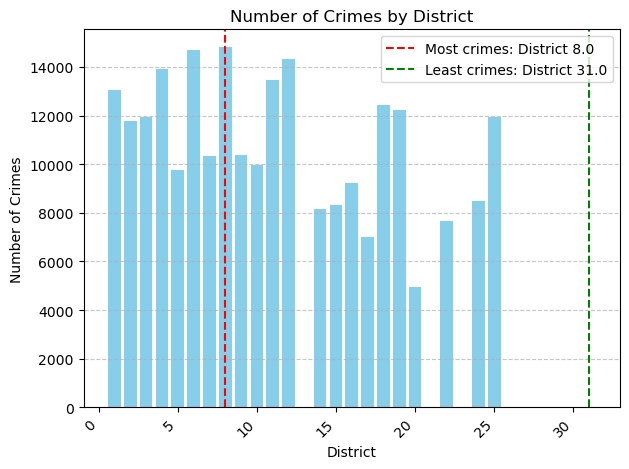

In [21]:
df_2022 = chicago_crimes.loc['2022']
district_crimes = df_2022.groupby('District').size()
most_crimes = district_crimes.idxmax()
least_crimes = district_crimes.idxmin()
plt.bar(district_crimes.index, district_crimes, color='skyblue')
plt.title('Number of Crimes by District')
plt.xlabel('District')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Draw vertical lines to highlight the districts with the most and least crimes
plt.axvline(most_crimes, color='red', linestyle='--', label=f'Most crimes: District {most_crimes}')
plt.axvline(least_crimes, color='green', linestyle='--', label=f'Least crimes: District {least_crimes}')

plt.legend()
plt.tight_layout()
plt.show()

# Topic 2 : 
Comparing months 

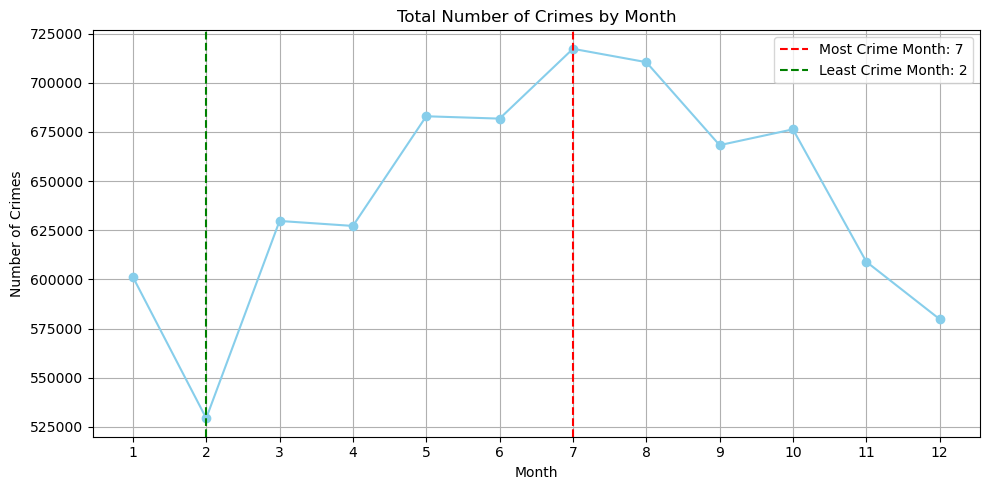

In [25]:
df = chicago_crimes.copy()
df['Month'] = df.index.month

monthly_crimes = df.groupby('Month').size()
plt.figure(figsize=(10, 5))
plt.plot(monthly_crimes.index, monthly_crimes, marker='o', linestyle='-', color='skyblue')
plt.title('Total Number of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 13))
most_crime_month = monthly_crimes.idxmax()
plt.axvline(most_crime_month, color='red', linestyle='--', label=f'Most Crime Month: {most_crime_month}')
least_crime_month = monthly_crimes.idxmin()
plt.axvline(least_crime_month, color='green', linestyle='--', label=f'Least Crime Month: {least_crime_month}')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

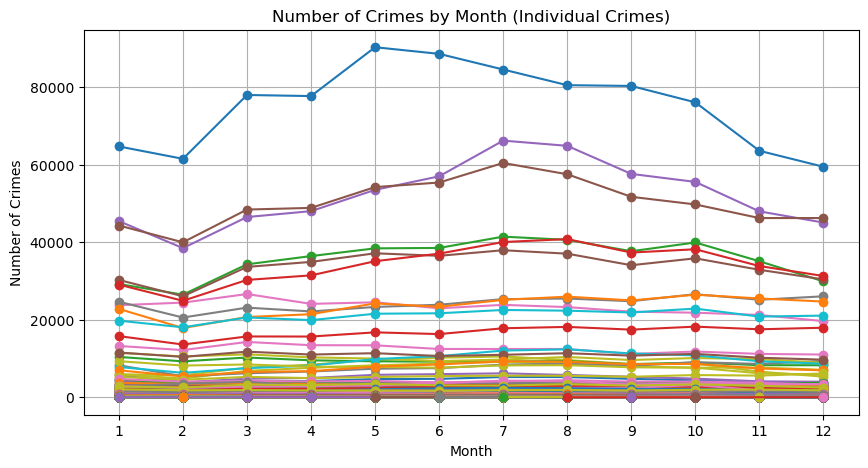

In [26]:
plt.figure(figsize=(10, 5))
for crime in df['Description'].unique():
    monthly_crimes = df[df['Description'] == crime].groupby('Month').size()
    plt.plot(monthly_crimes.index, monthly_crimes, marker='o', linestyle='-', label=crime)

plt.title('Number of Crimes by Month (Individual Crimes)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 13))

plt.grid(True)

plt.show()

# Topic 3 : 
Comparing holidays

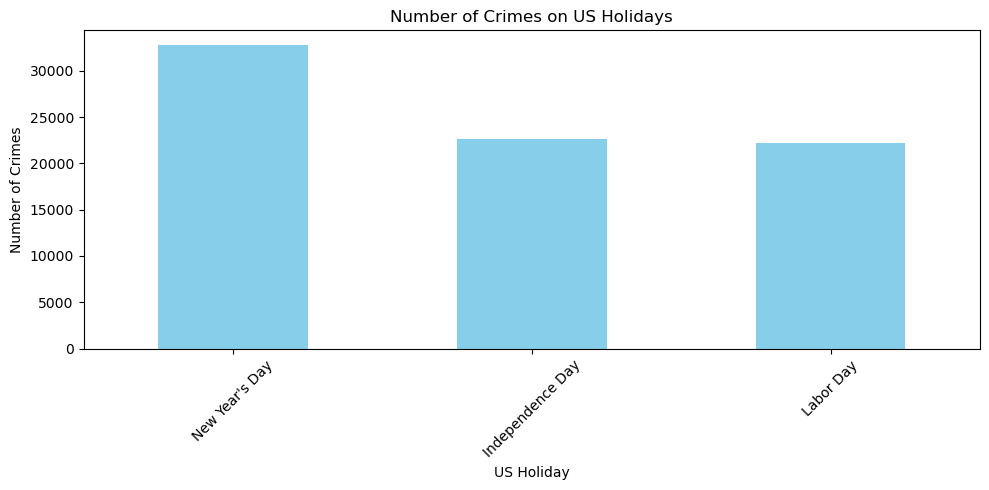

In [37]:
df1 = df.copy()
df_daily = df1.resample('D').sum(numeric_only=True)
us_holidays = holidays.US()

# Map dates to US holiday names
df1['US Holiday Name'] = df1.index.map(lambda x: us_holidays.get(x))

# Filter out rows where US Holiday Name is not None
df1_filtered = df1[df1['US Holiday Name'].notna()]

# Task 4: Identify top 3 US holidays with the largest number of crimes
top_3_us_holidays = df1_filtered.groupby('US Holiday Name').size().nlargest(3)

# Plot number of crimes for each US holiday (if holidays exist)
if not top_3_us_holidays.empty:
    plt.figure(figsize=(10, 5))
    top_3_us_holidays.plot(kind='bar', color='skyblue')
    plt.title('Number of Crimes on US Holidays')
    plt.xlabel('US Holiday')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for US holidays.")

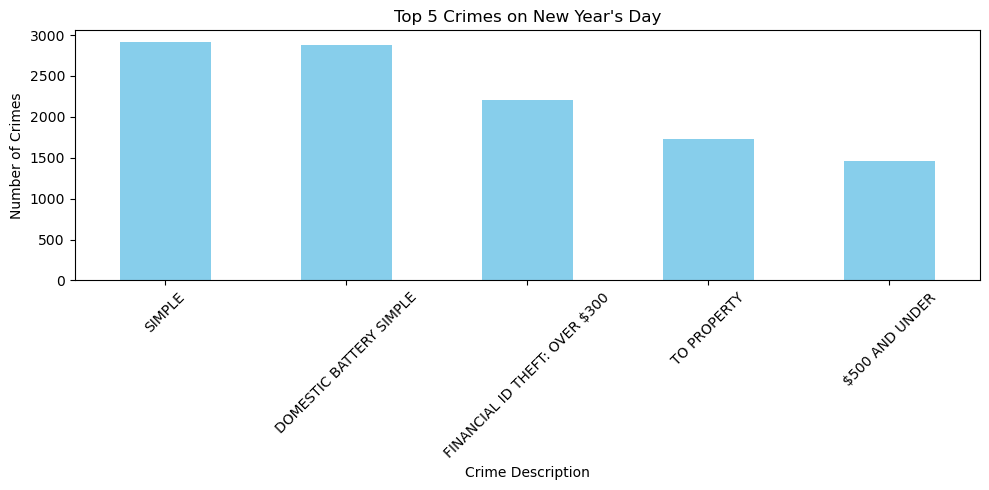

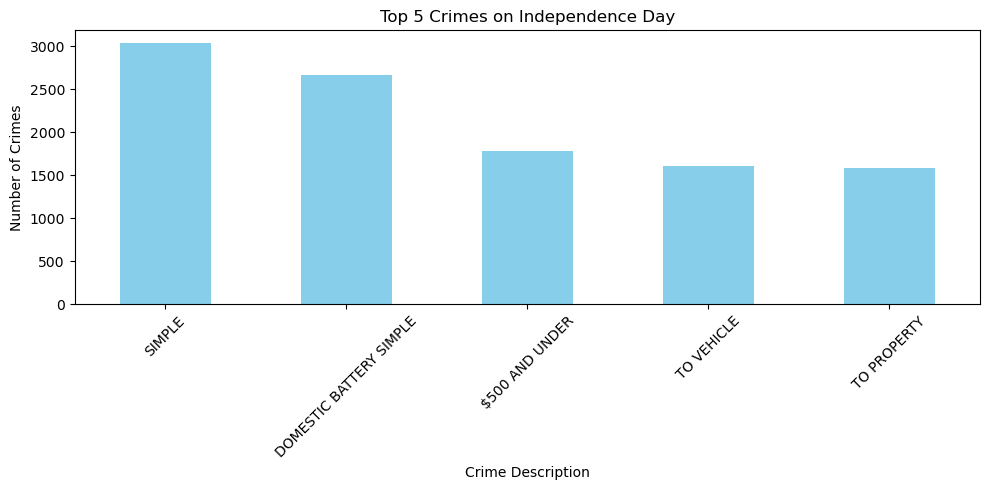

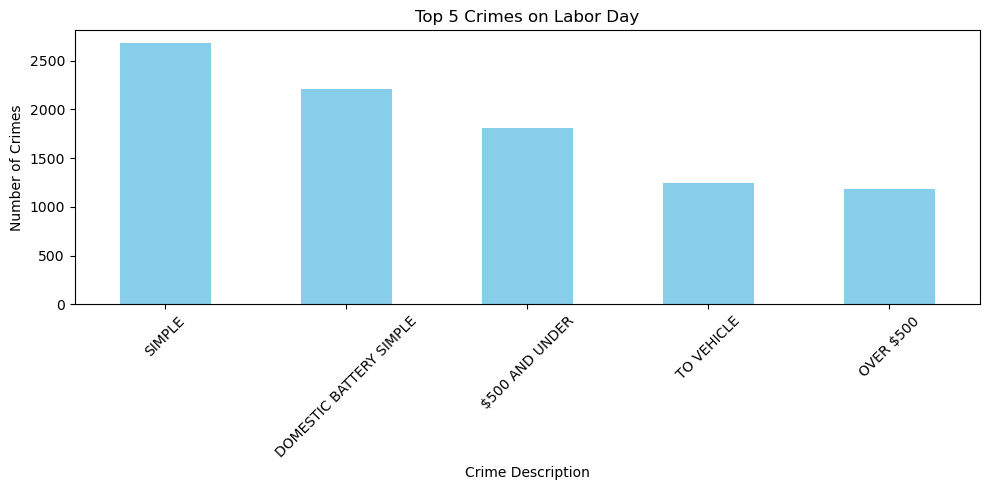

In [39]:
for holiday in top_3_us_holidays.index:
    plt.figure(figsize=(10, 5))
    crimes_on_holiday = df1_filtered[df1_filtered['US Holiday Name'] == holiday]['Description'].value_counts().head(5)
    crimes_on_holiday.plot(kind='bar', color='skyblue')
    plt.title(f'Top 5 Crimes on {holiday}')
    plt.xlabel('Crime Description')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()